In [1]:
import copy
import pickle
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from astropy.timeseries import LombScargle

import radvel
from radvel.plot import orbit_plots, mcmc_plots

import rvsearch
from rvsearch import search, utils

import sval_correlations

%matplotlib inline

# Notebook for handling data post-processing, such as S-value decorrelation, and modeling of yearly systematics.

## Investigate the mysterious case of HD 168009. Before handling yearly APF systematics, de-correlate both HIRES and APF data from long-term stellar activity cycle.

In [2]:
post_16 = radvel.posterior.load('../rvsearch_testing/168009/post_final.pkl')

data_16 = pd.read_csv('../rvdata/vst168009.csv')
data_16 = data_16.query('tel != "lick" and svalue > 0.0001 and \
                        svalue < 0.2 and mnvel > -10').reset_index()
#data_16 = data_16.query('tel != "lick" and svalue > 0.0001 and svalue < 0.2 and mnvel > -10')

data_hires = data_16.query('tel == "j"')
data_apf   = data_16.query('tel == "apf"')

svals = {}
svals['j'] = data_hires.svalue
svals['apf'] = data_apf.svalue

linfit = {}

In [3]:
sval  = svals['j']
mnvel_tot = data_hires.mnvel
# Subtract planet signal.
orbel = [post_16.params['per2'].value,
         post_16.params['tp2'].value,
         post_16.params['e2'].value,
         post_16.params['w2'].value,
         post_16.params['k2'].value]
mod  = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel)
mnvel = mnvel_tot - mod

errs  = np.sqrt(data_hires.errvel**2 +
                post_16.params['jit_j'].value**2)

A    = np.vstack((np.ones_like(sval), sval)).T
C    = np.diag(errs * errs)
cov  = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b, m = np.dot(cov, np.dot(A.T, np.linalg.solve(C, mnvel)))
sigb = np.sqrt(cov[0][0])
sigm = np.sqrt(cov[1][1])

linfit['hires'] = [b, m, sigb, sigm]
data_hires['mnvel'] = mnvel_tot - b - m*np.array(data_hires.svalue)

sval  = svals['apf']
mnvel_tot = data_apf.mnvel
# Subtract planet signal.
orbel = [post_16.params['per2'].value,
         post_16.params['tp2'].value,
         post_16.params['e2'].value,
         post_16.params['w2'].value,
         post_16.params['k2'].value]
mod  = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel)
mnvel = mnvel_tot - mod

errs  = np.sqrt(data_apf.errvel**2 +
                post_16.params['jit_apf'].value**2)

A    = np.vstack((np.ones_like(sval), sval)).T
C    = np.diag(errs * errs)
cov  = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b, m = np.dot(cov, np.dot(A.T, np.linalg.solve(C, mnvel)))
sigb = np.sqrt(cov[0][0])
sigm = np.sqrt(cov[1][1])

linfit['apf'] = [b, m, sigb, sigm]
data_apf['mnvel'] = mnvel_tot - b - m*np.array(data_apf.svalue)

In [5]:
#data_mod = data_hires.append(data_apf, ignore_index=True)
data_mod = data_16

## Using activity-decorrelated data, set up Gaussian Process fit for yearly systematic in APF data.

In [6]:
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_explength', # eta_2; GP non-periodic characteristic length
    'gp_per', # eta_3; GP variability period
    'gp_perlength', # eta_4; GP periodic characteristic length
]

### Set up a posterior/likelihood with the new sub-Neptune, and a GP for the APF data. NO LICK DATA.

In [6]:
post_16.params

Parameters([('per1',
             Parameter object: value = 367.9345319951641, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 2457602.954520221, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = 0.3697628558536885, vary = True, mcmc scale = 0.005),
            ('sesinw1',
             Parameter object: value = 0.6847437837764128, vary = True, mcmc scale = 0.005),
            ('k1',
             Parameter object: value = 3.574510937930028, vary = True, mcmc scale = None),
            ('per2',
             Parameter object: value = 15.148985403888968, vary = True, mcmc scale = None),
            ('tc2',
             Parameter object: value = 2455201.5866734744, vary = True, mcmc scale = None),
            ('secosw2',
             Parameter object: value = -0.31462943594510284, vary = True, mcmc scale = 0.005),
            ('sesinw2',
             Parameter object: value = -0.20120308544502738, vary

In [7]:
t = np.array(data_mod.jd)
vel = np.array(data_mod.mnvel)
errvel = np.array(data_mod.errvel)
tel = np.array(data_mod.tel)

telgrps = data_mod.groupby('tel').groups
instnames = telgrps.keys()

In [8]:
nplanets = 1
params = radvel.Parameters(nplanets, basis='per tc secosw sesinw k')

params['per1'] = radvel.Parameter(value=15.1489854, vary=True)
params['tc1'] = radvel.Parameter(value=2455201.5866734744, vary=True)
params['secosw1'] = radvel.Parameter(value=-0.3146294,vary=True)#=0, vary=False)
params['sesinw1'] = radvel.Parameter(value=-0.2012031,vary=True)#=0, vary=False)
params['k1'] = radvel.Parameter(value=2.5916, vary=True)
params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

amp       = 2.98
explength = 2000 #Model activity with sub-baseline exponential term #10000
per       = 365.25
perlength = 0.5

params['gp_amp'] = radvel.Parameter(value=amp, vary=True)
params['gp_explength'] = radvel.Parameter(value=explength, vary=True)
params['gp_per'] = radvel.Parameter(value=per, vary=True)
params['gp_perlength'] = radvel.Parameter(value=perlength, vary=True)

#params['gp_amp_apf'] = radvel.Parameter(value=amp, vary=True)
#params['gp_explength_apf'] = radvel.Parameter(value=explength, vary=True)
#params['gp_per_apf'] = radvel.Parameter(value=per, vary=True)
#params['gp_perlength_apf'] = radvel.Parameter(value=perlength, vary=True)

### Initialize likelihood and posterior models. Include strong priors on GP hyperparameters.

In [9]:
model = radvel.model.RVModel(params)

# Make HIRES likelihood.
indices = telgrps['j']
like_hires = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                            errvel[indices], hnames, 
                                            suffix='_j',
                                            kernel_name="QuasiPer"
                                            )
like_hires.params['gamma_j'] = radvel.Parameter(value=-0.2894, vary=False, linear=True)
like_hires.params['jit_j'] = radvel.Parameter(value=3.338, vary=True)

# Make APF likelihood.
indices = telgrps['apf']
like_apf = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                          errvel[indices], hnames, 
                                          suffix='_apf',
                                          kernel_name="QuasiPer"
                                          )
like_apf.params['gamma_apf'] = radvel.Parameter(value=-1.7889, vary=False, linear=True)
like_apf.params['jit_apf'] = radvel.Parameter(value=3.670, vary=True)

likes = [like_hires, like_apf]

In [10]:
like_hires

parameter                     value      vary
per1                         15.149       True
tc1                      2.4552e+06       True
secosw1                   -0.314629       True
sesinw1                   -0.201203       True
k1                           2.5916       True
dvdt                              0      False
curv                              0      False
gp_amp                         2.98       True
gp_explength                   2000       True
gp_per                       365.25       True
gp_perlength                    0.5       True
gamma_j                     -0.2894      False
jit_j                         3.338       True
gamma_apf                   -1.7889      False
jit_apf                        3.67       True

In [11]:
gplike = radvel.likelihood.CompositeLikelihood(likes)

In [12]:
gppost = radvel.posterior.Posterior(gplike)

gppost.priors += [radvel.prior.Jeffreys('gp_amp', 0.01, 100.)]
gppost.priors += [radvel.prior.Gaussian('gp_per', per, 10.)]
gppost.priors += [radvel.prior.Gaussian('gp_perlength', perlength, 0.05)]
gppost.priors += [radvel.prior.Gaussian('gp_explength', explength, 200.)]
#gppost.priors += [radvel.prior.Gaussian('per1', Porb, Porb_unc)]
#gppost.priors += [radvel.prior.Gaussian('tc1', Tc, Tc_unc)]
#gppost.priors += [radvel.prior.Jeffreys('k1', 0.01, 10.)] # min and max for Jeffrey's priors estimated by Sarah
#gppost.priors += [radvel.prior.Jeffreys('jit_j', 0.01, 10.)]
#gppost.priors += [radvel.prior.Jeffreys('jit_apf', 0.01,10.)]

In [14]:
res = optimize.minimize(
      gppost.neglogprob_array, gppost.get_vary_params(), method='Powell',
      options=dict(maxiter=500, maxfev=100000, xatol=1e-8)
      )
print(gppost)

parameter                     value      vary
per1                        15.1446       True
tc1                      2.4552e+06       True
secosw1                   -0.215107       True
sesinw1                   -0.483152       True
k1                          2.38403       True
dvdt                              0      False
curv                              0      False
gp_amp                      2.81408       True
gp_explength                2000.44       True
gp_per                      367.684       True
gp_perlength               0.453757       True
gamma_j                     -0.2894      False
jit_j                       2.34275       True
gamma_apf                   -1.7889      False
jit_apf                     3.77776       True

Priors
------
Jeffrey's prior on gp_amp, min=0.01, max=100.0
Gaussian prior on gp_per, mu=365.25, sigma=10.0
Gaussian prior on gp_perlength, mu=0.5, sigma=0.05
Gaussian prior on gp_explength, mu=2000, sigma=200.0



In [23]:
nwalkers = 50
nrun = 1000
chains = radvel.mcmc(gppost, nwalkers=nwalkers, nrun=nrun, burnGR=1.03,
                     maxGR=1.0075, minTz=2000, minAfactor=15,
                     maxArchange=0.07, burnAfactor=15,
                     minsteps=0.5*nwalkers*nrun, minpercent=50, thin=5,
                     save=False, ensembles=8)

#chains = radvel.mcmc(gppost, nrun=500, ensembles=5, minAfactor=15, 
#                     maxArchange=0.03, burnAfactor=15, burnGR=1.05,
#                     savename='rawchains.h5')

error: must call initscr() first

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 1.51398504e+01  2.45520359e+06  2.98353529e-02 -5.67332554e-01
  1.35238931e+00  2.31007345e+00  1.03454807e+04  3.69225121e+02
  4.44826739e-01  1.96100123e+00  3.75110135e+00]  params: [ 1.51433902e+01  2.45520209e+06 -3.88688686e-01 -1.94854703e-01
  2.22973235e+00  3.10121177e+00  9.86822084e+03  3.79069204e+02
  4.76354654e-01  2.67618857e+00  3.91176856e+00]
  args: []

  kwargs: {}
  args: []
  exception:
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 69, in logprob_array
    _logprob = self.logprob()
Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 53, in logprob
    return _logprob + self.likelihood.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/likelihood.py", line 224, in logprob
    _logprob += like.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 69, in logprob_array
    _logprob = self.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/likelihood.py", line 441, in l

emcee: Exception while calling your likelihood function:


  File "/Users/lee/anaconda/lib/python3.7/site-packages/scipy/linalg/decomp_cholesky.py", line 37, in _cholesky
    c, info = potrf(a1, lower=lower, overwrite_a=overwrite_a, clean=clean)
KeyboardInterrupt
  File "/Users/lee/anaconda/lib/python3.7/site-packages/scipy/linalg/decomp_cholesky.py", line 209, in cho_solve
    x, info = potrs(c, b1, lower=lower, overwrite_b=overwrite_b)


  params: [ 1.51445906e+01  2.45520169e+06 -3.16229021e-02 -4.68942862e-01
  1.91481481e+00  2.34016189e+00  9.85313838e+03  3.70151644e+02
  4.32411584e-01  2.75314573e+00  3.83304480e+00]

Process ForkPoolWorker-146:
KeyboardInterrupt


Process ForkPoolWorker-144:


  args: []


Traceback (most recent call last):


  kwargs: {}


  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


  exception:


Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/mcmc.py", line 182, in _domcmc
    sampler.run_mcmc(ipos, check_interval)
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/lee/anaconda/lib/python3.7/s

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:


  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 69, in logprob_array
    _logprob = self.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 53, in logprob
    return _logprob + self.likelihood.logprob()


  params: [ 1.51312239e+01  2.45520406e+06 -4.43687149e-01 -1.48416776e-01
  1.75948533e+00  3.99894197e+00  1.01609593e+04  3.66664680e+02
  4.39522046e-01  2.45541199e+00  3.94999924e+00]  params: [ 1.51323390e+01  2.45520321e+06 -9.12557390e-02 -3.56364303e-01
  1.30285331e+00  2.36173768e+00  9.95711963e+03  3.69124979e+02
  3.30116738e-01  2.01301364e+00  3.93721485e+00]



  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/likelihood.py", line 224, in logprob
    _logprob += like.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/likelihood.py", line 444, in logprob
    (s,d) = np.linalg.slogdet(K)


  args: []
  args: []


  File "/Users/lee/anaconda/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 2034, in slogdet
    sign, logdet = _umath_linalg.slogdet(a, signature=signature)


  kwargs: {}
  kwargs: {}
  exception:


KeyboardInterrupt


  exception:


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 69, in logprob_array
    _logprob = self.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 69, in logprob_array
    _logprob = self.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 53, in logprob
    return _logprob + self.likelihood.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 53, in logprob
    return _logprob + self.likelihood.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/likelihood.py",

emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-147:
KeyboardInterrupt
Process ForkPoolWorker-141:
Traceback (most recent call last):


  params: [ 1.51436601e+01  2.45520018e+06  3.14308705e-01 -4.86417206e-01
  2.57311060e+00  5.12809657e+00  9.88102185e+03  3.71165045e+02
  4.94646199e-01  2.71307739e+00  3.56967851e+00]

  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):


  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


  args: []


  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))


  kwargs: {}


  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))


  exception:


  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/mcmc.py", line 182, in _domcmc
    sampler.run_mcmc(ipos, check_interval)
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 384, in run_mcmc
    for results in self.sample(initial_state, iterations=nsteps, **kwargs):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/mcmc.py", line 182, in _domcmc
    sampler.run_mcmc(ipos, check_interval)
Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 343, in sample
    state, accepted = move.propose(model, state)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 384, in run_mcmc
    for results in self.sampl

emcee: Exception while calling your likelihood function:


Traceback (most recent call last):


emcee: Exception while calling your likelihood function:


KeyboardInterrupt
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


  params: [ 1.51428476e+01  2.45520242e+06  3.61754311e-02 -3.85305588e-01
  1.90584488e+00  4.87267244e+00  9.84760807e+03  3.73883046e+02
  5.54757428e-01  2.89993243e+00  3.71432070e+00]  params: [ 1.51462281e+01  2.45520200e+06 -1.97755594e-01 -3.19638313e-01
  1.98799161e+00  3.64470741e+00  1.01026502e+04  3.70464756e+02
  4.63652822e-01  2.34715527e+00  3.70967024e+00]

  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))


  File "/Users/lee/anaconda/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))



  args: []


  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/mcmc.py", line 182, in _domcmc
    sampler.run_mcmc(ipos, check_interval)


  args: []
  kwargs: {}


  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 384, in run_mcmc
    for results in self.sample(initial_state, iterations=nsteps, **kwargs):


  exception:


  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 343, in sample
    state, accepted = move.propose(model, state)


  kwargs: {}


  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/moves/red_blue.py", line 93, in propose
    new_log_probs, new_blobs = model.compute_log_prob_fn(q)


  exception:


  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 427, in compute_log_prob
    map_func(self.log_prob_fn, (p[i] for i in range(len(p))))
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 69, in logprob_array
    _logprob = self.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/lee/anaconda/lib/python3.7/site-packages/radvel/posterior.py", line 69, in logprob_array
    _logprob = self.logprob()
  File "/Users/lee/anaconda/lib/python3.7/site-packages/

RV multi-panel plot saved to 168009_gp.pdf


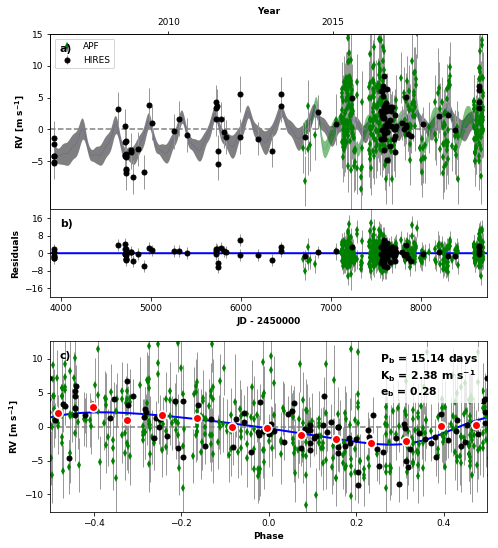

In [15]:
# try switching some of these (optional) keywords to "True" to see what they do!
GPPlot = orbit_plots.GPMultipanelPlot(
         gppost,
         saveplot='168009_gp.pdf',
         subtract_gp_mean_model=False,
         plot_likelihoods_separately=False,
         subtract_orbit_model=True
         )
GPPlot.plot_multipanel()

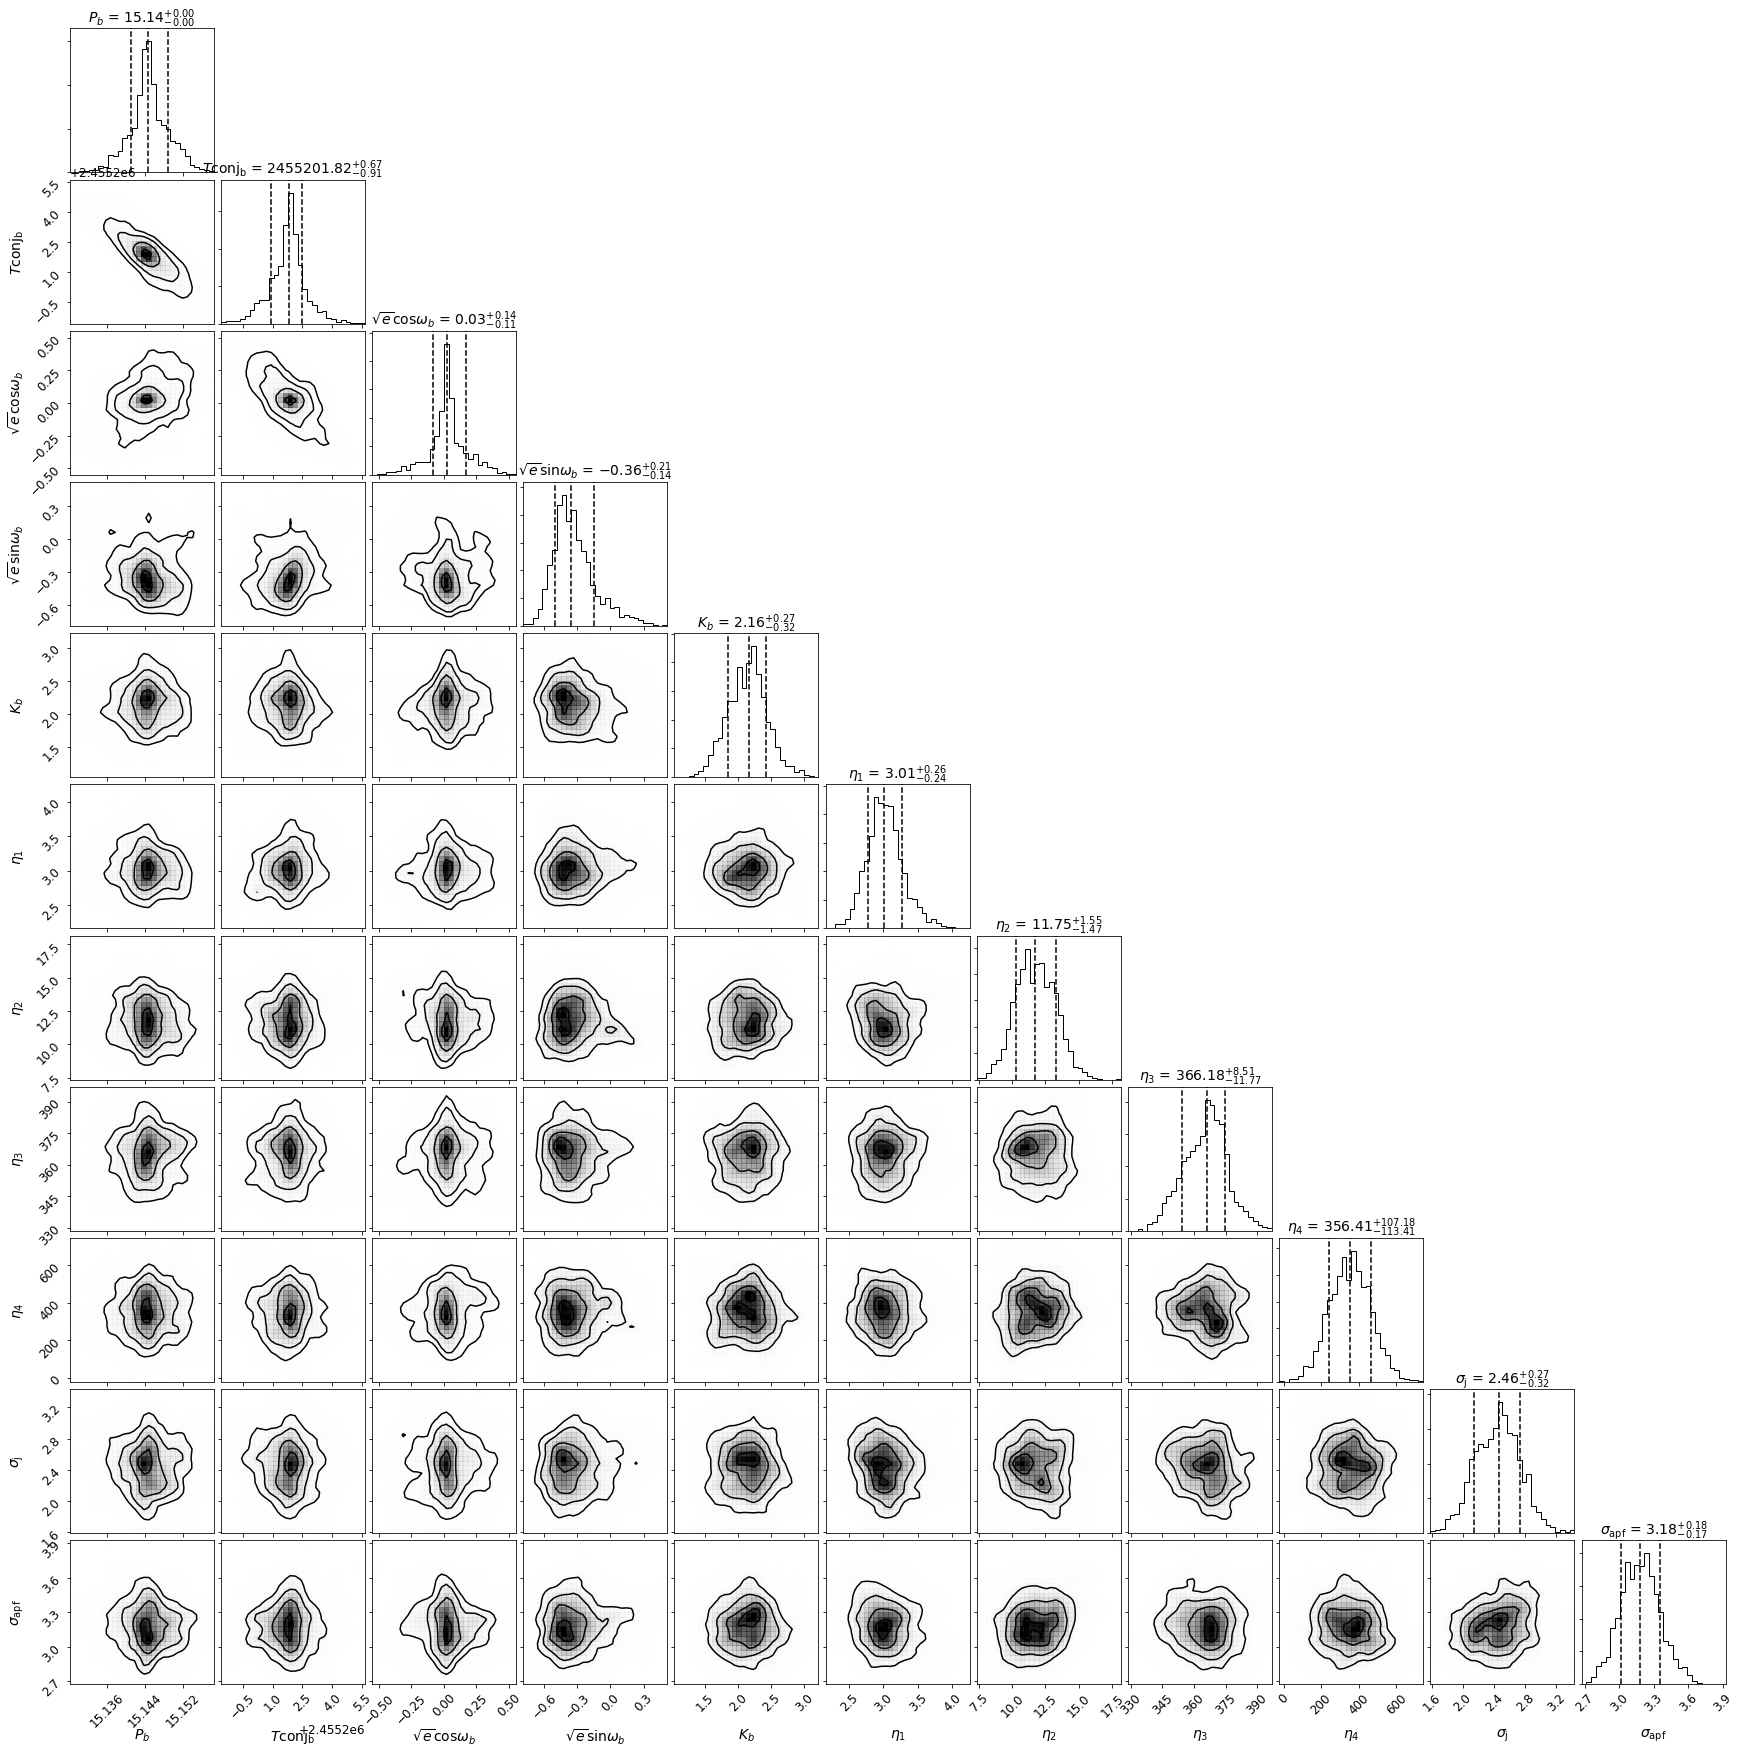

In [35]:
Corner = mcmc_plots.CornerPlot(gppost, chains[-5000:]) # posterior distributions
Corner.plot()

chains[-5000:].to_csv('168009_gp_chains.csv')

In [8]:
nplanets = 1
params = radvel.Parameters(nplanets, basis='per tc secosw sesinw k')

params['per1'] = radvel.Parameter(value=15.1489854, vary=True)
params['tc1'] = radvel.Parameter(value=2455201.5866734744, vary=True)
params['secosw1'] = radvel.Parameter(value=-0.3146294,vary=True)
params['sesinw1'] = radvel.Parameter(value=-0.2012031,vary=True)
params['k1'] = radvel.Parameter(value=2.5916, vary=True)
params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

In [9]:
model = radvel.model.RVModel(params)

# Make HIRES likelihood.
indices = telgrps['j']
like_hires = radvel.likelihood.RVLikelihood(model, t[indices], vel[indices],
                                            errvel[indices], suffix='_j'
                                            )
like_hires.params['gamma_j'] = radvel.Parameter(value=-0.2894, vary=False, linear=True)
like_hires.params['jit_j'] = radvel.Parameter(value=3.338, vary=True)

# Make APF likelihood.
indices = telgrps['apf']
like_apf = radvel.likelihood.RVLikelihood(model, t[indices], vel[indices],
                                          errvel[indices], suffix='_apf'
                                          )
like_apf.params['gamma_apf'] = radvel.Parameter(value=-1.7889, vary=False, linear=True)
like_apf.params['jit_apf'] = radvel.Parameter(value=3.670, vary=True)

likes = [like_hires, like_apf]

In [10]:
normlike = radvel.likelihood.CompositeLikelihood(likes)
normpost = radvel.posterior.Posterior(normlike)

In [12]:
res = optimize.minimize(
      normpost.neglogprob_array, normpost.get_vary_params(), method='Powell',
      options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
      )
print(normpost)

parameter                     value      vary
per1                        15.1447       True
tc1                      2.4552e+06       True
secosw1                   -0.156348       True
sesinw1                   -0.390594       True
k1                          2.16099       True
dvdt                              0      False
curv                              0      False
gamma_j                  -0.0999868      False
jit_j                       3.20154       True
gamma_apf                  0.027625      False
jit_apf                     4.33658       True

Priors
------



In [19]:
chains = radvel.mcmc(normpost, nwalkers=50, nrun=25000, minAfactor=15, 
                     maxArchange=0.03, burnAfactor=15, burnGR=1.03,
                     maxGR=1.007, minpercent=30, minsteps=12500, 
                     savename='rawchains_norm.h5')

3000000/10000000 (30.0%) steps complete; Running 7833.72 steps/s; Mean acceptance rate = 35.3%; Min Auto Factor = 145; Max Auto Relative-Change = 0.603; Min Tz = 65111.6; Max G-R = 1.000
Discarding burn-in now that the chains are marginally well-mixed

3500000/10000000 (35.0%) steps complete; Running 10716.32 steps/s; Mean acceptance rate = 34.8%; Min Auto Factor =  36; Max Auto Relative-Change = 0.025; Min Tz = 8991.5; Max G-R = 1.0033
Chains are well-mixed after 3500000 steps! MCMC completed in 5.9 minutes




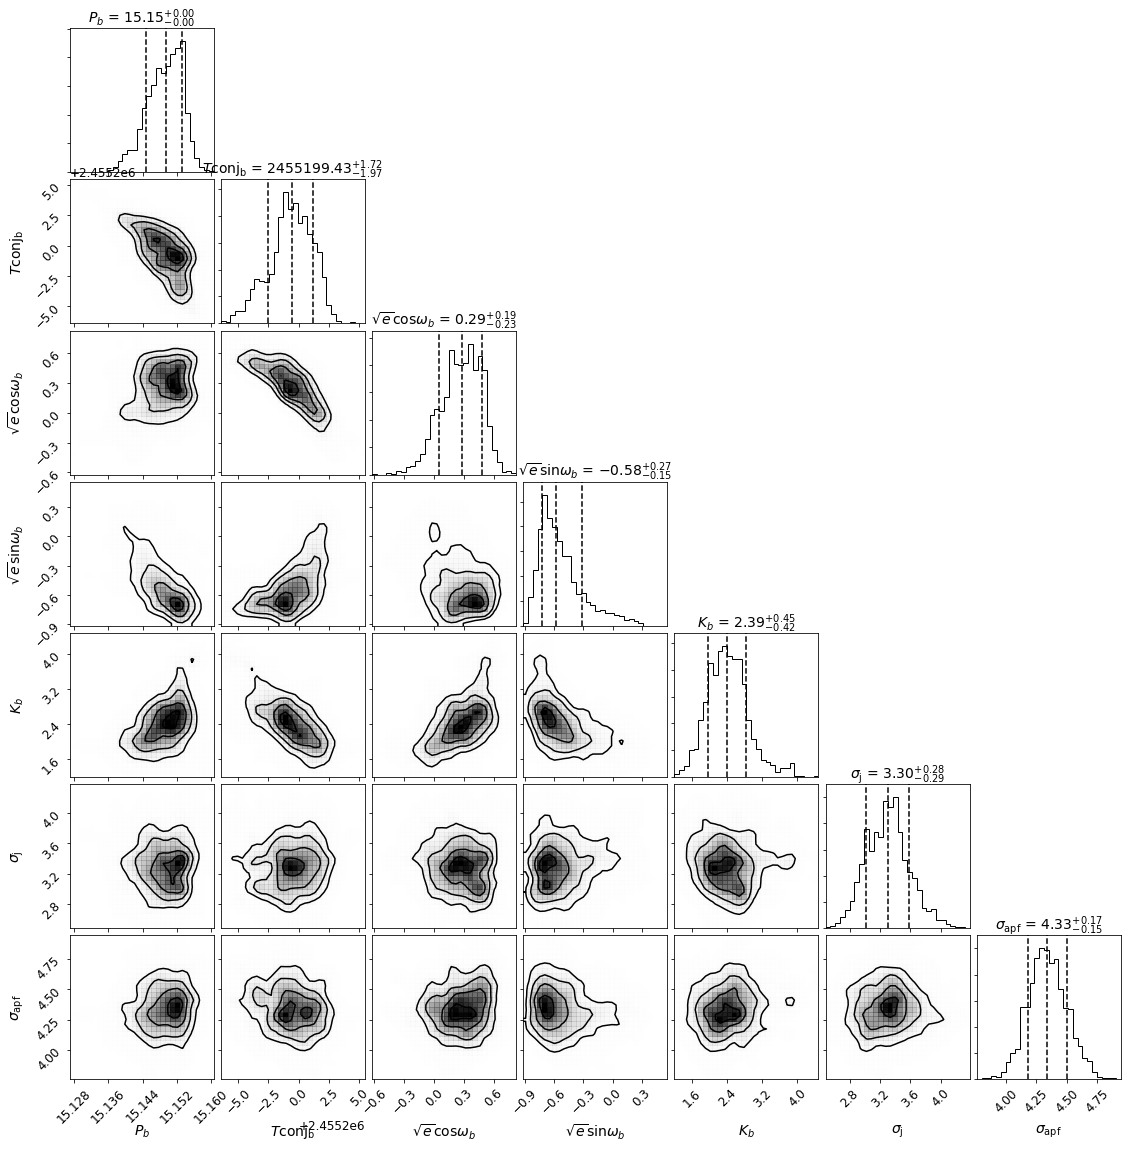

In [21]:
Corner = mcmc_plots.CornerPlot(normpost, chains[-10000:]) # posterior distributions
Corner.plot()

chains.to_csv('168009_norm_chains.csv')

In [2]:
post_15 = radvel.posterior.load('../rvsearch_testing/156668/post_final.pkl')

data_15 = pd.read_csv('../rvdata/vst156668.csv')
data_15 = data_15.query('tel != "k" and mnvel > -11 and cts > 3000 and svalue > .08')# and svalue > 0.0001 and svalue < 0.2 and mnvel > -10')

data_hires = data_15.query('tel == "j"')
data_apf   = data_15.query('tel == "apf"')

svals = {}
svals['j'] = data_hires.svalue
svals['apf'] = data_apf.svalue

linfit = {}

In [3]:
np.median(svals['apf'])

0.2656745401365

In [4]:
sval  = svals['j']
mnvel_tot = data_hires.mnvel
# Subtract planet signal.
orbel1 = [post_15.params['per1'].value,
          post_15.params['tp1'].value,
          post_15.params['e1'].value,
          post_15.params['w1'].value,
          post_15.params['k1'].value]
orbel2 = [post_15.params['per2'].value,
          post_15.params['tp2'].value,
          post_15.params['e2'].value,
          post_15.params['w2'].value,
          post_15.params['k2'].value]
mod1  = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel1)
mod2  = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel2)
mnvel = mnvel_tot - mod1 - mod2

errs  = np.sqrt(data_hires.errvel**2 +
                post_15.params['jit_j'].value**2)

A    = np.vstack((np.ones_like(sval), sval)).T
C    = np.diag(errs * errs)
cov  = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b, m = np.dot(cov, np.dot(A.T, np.linalg.solve(C, mnvel)))
sigb = np.sqrt(cov[0][0])
sigm = np.sqrt(cov[1][1])

linfit['hires'] = [b, m, sigb, sigm]
data_hires['mnvel'] = mnvel_tot - b - m*np.array(data_hires.svalue)

sval  = svals['apf']
mnvel_tot = data_apf.mnvel
# Subtract planet signal.
mod1  = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel1)
mod2  = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel2)
mnvel = mnvel_tot - mod1 - mod2

errs  = np.sqrt(data_apf.errvel**2 +
                post_15.params['jit_apf'].value**2)

A    = np.vstack((np.ones_like(sval), sval)).T
C    = np.diag(errs * errs)
cov  = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b, m = np.dot(cov, np.dot(A.T, np.linalg.solve(C, mnvel)))
sigb = np.sqrt(cov[0][0])
sigm = np.sqrt(cov[1][1])

linfit['apf'] = [b, m, sigb, sigm]
data_apf['mnvel'] = mnvel_tot - b - m*np.array(data_apf.svalue)

In [5]:
data_mod = data_hires.append(data_apf, ignore_index=True)

In [6]:
data_mod.to_csv('vst156668_decorrelate.csv')

In [7]:
data_mod

,date,observation_id,tel,jd,mnvel,errvel,cts,mdchi,bc,svalue,svalue_err,trv,trv_err
0,2005-04-18 11:32:27.840,j07.142,j,2.453479e+06,1.385646,0.949501,98211.0,1.403290,13611.750,0.201000,0.001,NaN,NaN
1,2005-06-26 09:55:49.349,j08.580,j,2.453548e+06,-2.321169,1.007699,101858.0,1.430841,-6140.641,0.214000,0.001,-44.65,0.1
2,2005-08-22 08:10:27.798,j11.943,j,2.453605e+06,-3.462527,0.987774,107248.0,1.384501,-17705.274,0.212000,0.001,-44.69,0.1
3,2006-03-12 15:29:12.000,j17.203,j,2.453807e+06,3.482551,1.077722,56526.0,1.293475,18381.688,0.222000,0.001,-44.54,0.1
4,2006-07-16 10:07:58.673,j20.883,j,2.453933e+06,1.722643,0.966648,98026.0,1.291609,-11499.345,0.229000,0.001,-44.59,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,2014-03-15 09:36:12.782,ade.218,apf,2.456732e+06,4.792617,4.074329,4044.0,1.145152,18462.783,0.222379,0.002,NaN,NaN
751,2018-05-23 08:48:41.439,beq.223,apf,2.458262e+06,-0.860202,2.392151,13217.0,1.305681,4288.514,0.270983,0.002,NaN,NaN
752,2015-07-05 07:50:07.138,ake.253,apf,2.457209e+06,-5.441877,2.613546,8584.0,1.228792,-8513.897,0.212846,0.002,NaN,NaN
753,2014-03-19 12:27:02.149,adg.224,apf,2.456736e+06,4.038771,3.037481,5548.0,1.164159,18007.263,0.233402,0.002,NaN,NaN


In [8]:
np.median(data_mod['mnvel'])

-0.6446312662283127

In [9]:
data_mod.cts

0       98211.0
1      101858.0
2      107248.0
3       56526.0
4       98026.0
         ...   
750      4044.0
751     13217.0
752      8584.0
753      5548.0
754     11944.0
Name: cts, Length: 755, dtype: float64

## Check results from cadence.

In [3]:
chains = pd.read_csv('../neptune_twins/chains.csv.tar.bz2')

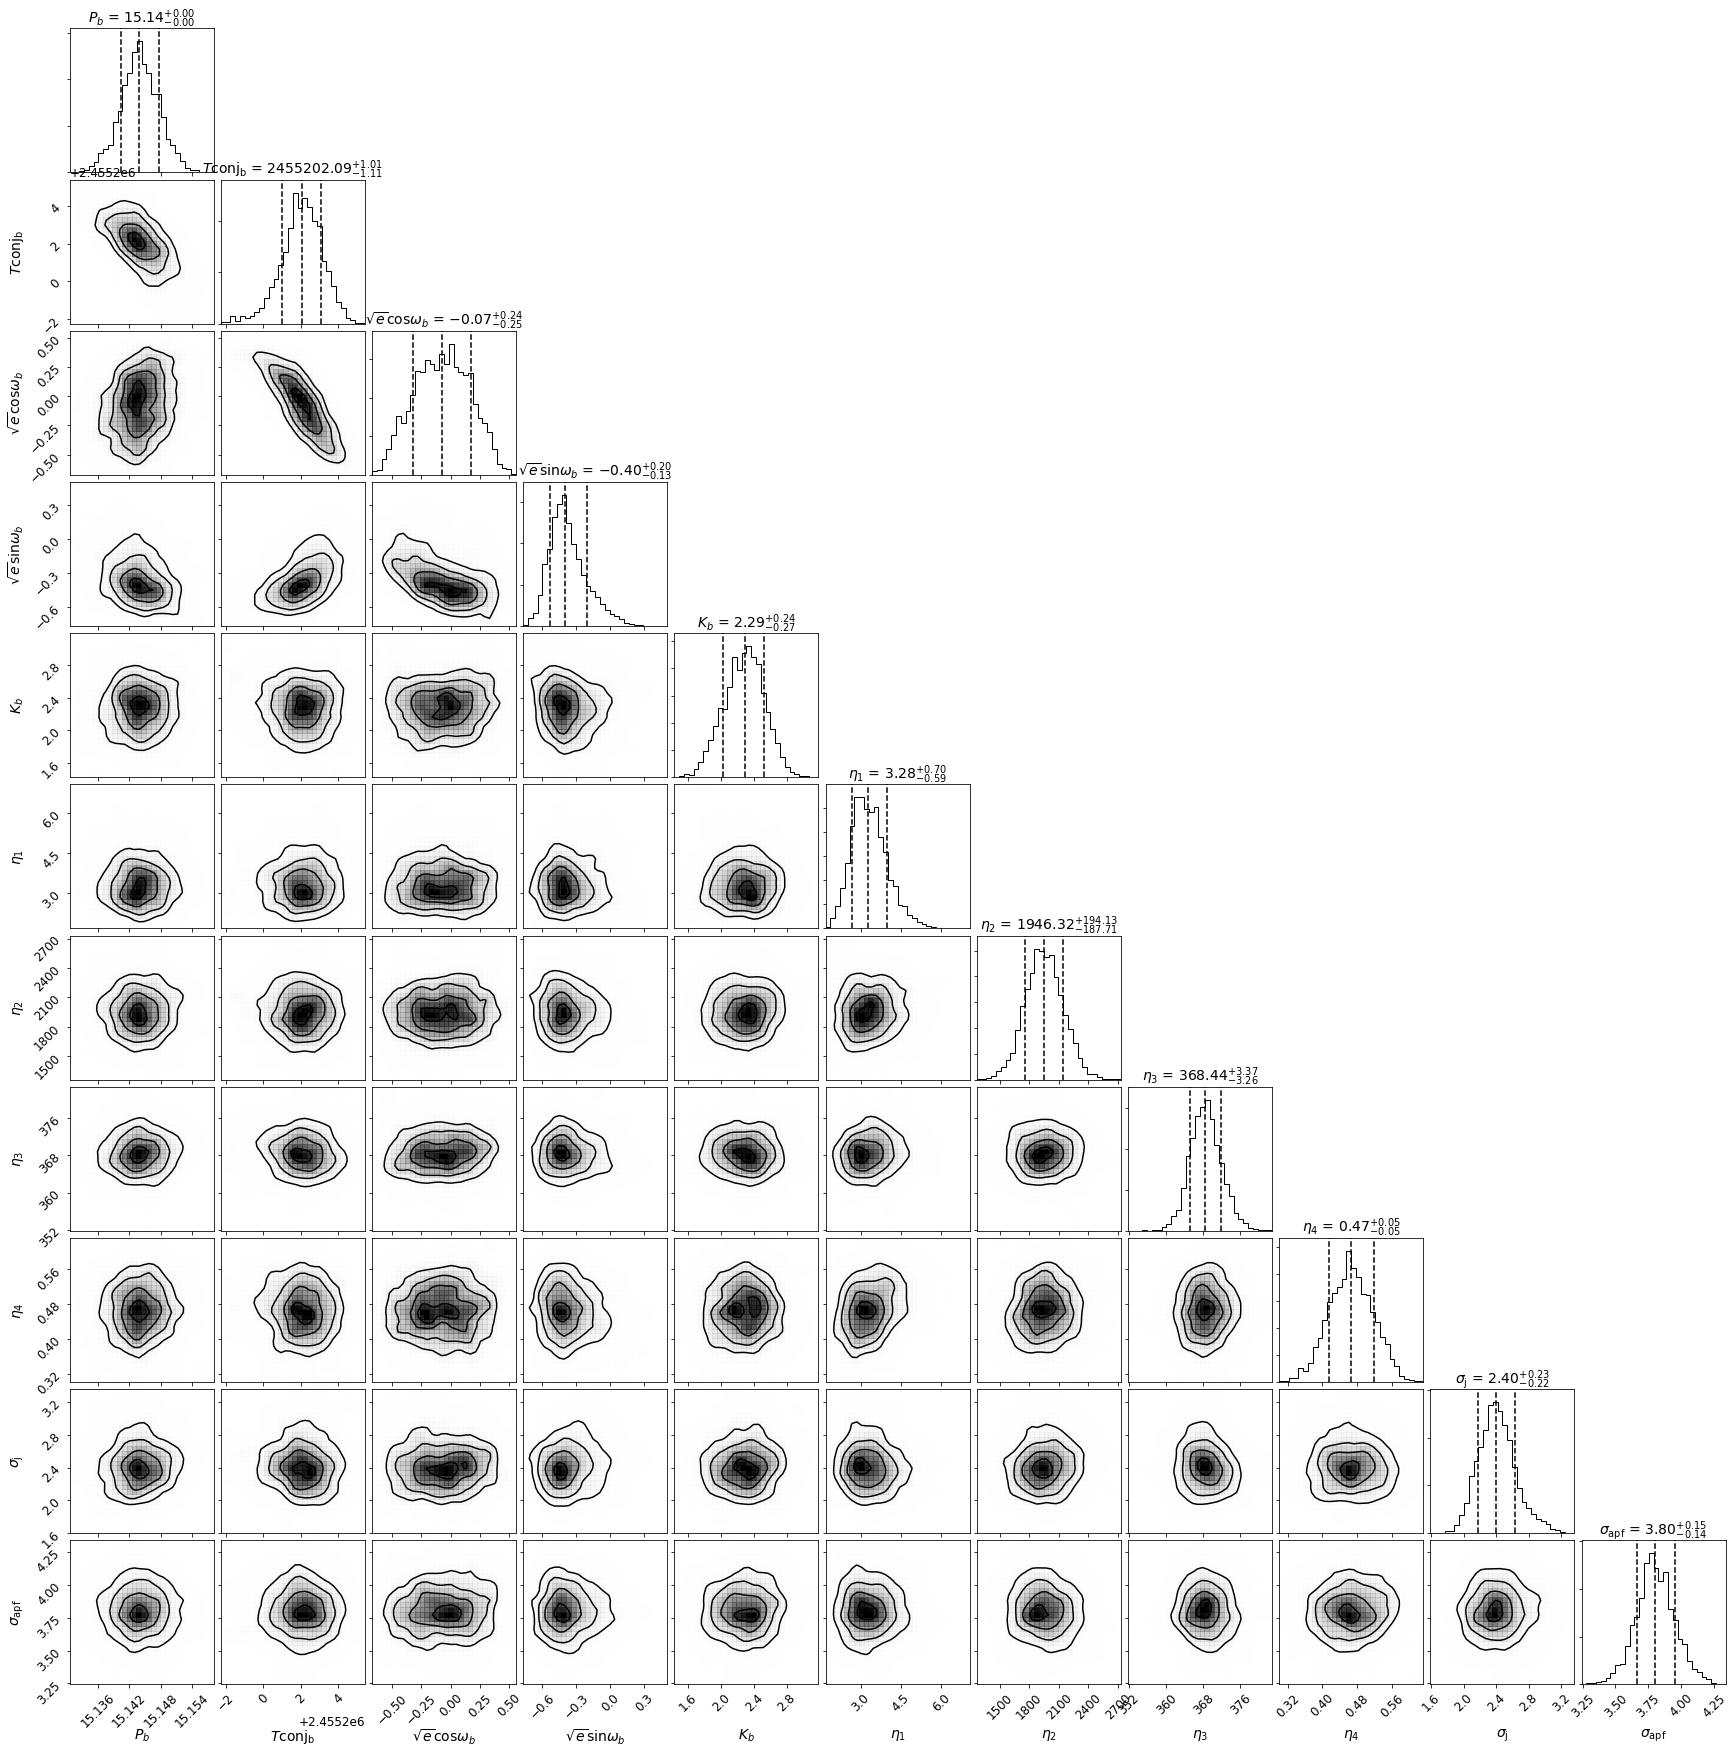

In [13]:
Corner = mcmc_plots.CornerPlot(gppost, chains[-5000:])
Corner.plot()

## Model HD 3765 activity with square-exponential kernel. Set up the file here, run on cadence.

In [4]:
post = radvel.posterior.load('../3765/post_final.pkl')
data = pd.read_csv('../rvdata/vst3765.csv')

In [6]:
t = np.array(data.jd)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

In [5]:
post.params

Parameters([('per1',
             Parameter object: value = 1235.8553164376942, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 2455618.025629988, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = -0.012123674495171316, vary = True, mcmc scale = 0.005),
            ('sesinw1',
             Parameter object: value = -0.6324900170543468, vary = True, mcmc scale = 0.005),
            ('k1',
             Parameter object: value = 4.013436136166362, vary = True, mcmc scale = None),
            ('jit_j',
             Parameter object: value = 3.027068490583884, vary = True, mcmc scale = None),
            ('jit_k',
             Parameter object: value = 4.799254850767471, vary = True, mcmc scale = None),
            ('gamma_j',
             Parameter object: value = -0.6631529318729545, vary = False, mcmc scale = None),
            ('gamma_k',
             Parameter object: value = -0.47255188547620375,

In [10]:
nplanets = 1
params = radvel.Parameters(nplanets, basis='per tc secosw sesinw k')

params['per1'] = radvel.Parameter(value=1235.855, vary=True)
params['tc1'] = radvel.Parameter(value=2455618.0256, vary=True)
params['secosw1'] = radvel.Parameter(value=-0.01212367,vary=True)
params['sesinw1'] = radvel.Parameter(value=-0.63249002,vary=True)
params['k1'] = radvel.Parameter(value=4.0134, vary=True)
params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

#Model activity with square-exponential term.
amp       = 2.98
explength = 1500 

params['gp_amp'] = radvel.Parameter(value=amp, vary=True)
params['gp_length'] = radvel.Parameter(value=explength, vary=True)

In [11]:
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_length' # eta_2; GP non-periodic characteristic length
]

model = radvel.model.RVModel(params)

# Make HIRES post-upgrade likelihood.
indices = telgrps['j']
like_j = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                            errvel[indices], hnames, 
                                            suffix='_j',
                                            kernel_name="SqExp"
                                            )
like_j.params['gamma_j'] = radvel.Parameter(value=-0.2894, vary=False, linear=True)
like_j.params['jit_j'] = radvel.Parameter(value=3.338, vary=True)

# Make HIRES pre-upgrade likelihood.
indices = telgrps['k']
like_k = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                          errvel[indices], hnames, 
                                          suffix='_k',
                                          kernel_name="SqExp"
                                          )
like_k.params['gamma_k'] = radvel.Parameter(value=-1.7889, vary=False, linear=True)
like_k.params['jit_k'] = radvel.Parameter(value=3.670, vary=True)

likes = [like_j, like_k]

In [43]:
gplike = radvel.likelihood.CompositeLikelihood(likes)
gppost = radvel.posterior.Posterior(gplike)
gppost.priors += [radvel.prior.Jeffreys('gp_amp', 0.01, 50.)]
gppost.priors += [radvel.prior.HardBounds('gp_length', 0, 8000)]
#gppost.priors += [radvel.prior.Gaussian('gp_length', explength, 1000.)]

In [45]:
res = optimize.minimize(
      gppost.neglogprob_array, gppost.get_vary_params(), method='Powell',
      options=dict(maxiter=500, maxfev=100000, xatol=1e-8)
      )
print(gppost)

parameter                     value      vary
per1                         1214.3       True
tc1                     2.45561e+06       True
secosw1                -0.000925049       True
sesinw1                   -0.544348       True
k1                          3.83751       True
dvdt                              0      False
curv                              0      False
gp_amp                      1.74796       True
gp_length                   1087.85       True
gamma_j                     -0.2894      False
jit_j                       2.68173       True
gamma_k                     -1.7889      False
jit_k                       3.91615       True
tp1                     2.45622e+06           
e1                         0.297675           
w1                         -1.57496           

Priors
------
Jeffrey's prior on gp_amp, min=0.01, max=50.0
Bounded prior on gp_length, min=0, max=8000



In [46]:
nwalkers = 20
nrun = 100
chains = radvel.mcmc(gppost, nwalkers=nwalkers, nrun=nrun, burnGR=1.03,
                     maxGR=1.0075, minTz=2000, minAfactor=15,
                     maxArchange=0.07, burnAfactor=15,
                     minsteps=0.5*nwalkers*nrun, minpercent=20, thin=5,
                     save=False, ensembles=12)

12000/24000 (50.0%) steps complete; Running 41.57 steps/s; Mean acceptance rate = 47.1%; Min Auto Factor =  27; Max Auto Relative-Change = 0.423; Min Tz = 6031.1; Max G-R = 1.011
Discarding burn-in now that the chains are marginally well-mixed

24000/24000 (100.0%) steps complete; Running 47.11 steps/s; Mean acceptance rate = 35.1%; Min Auto Factor =  18; Max Auto Relative-Change = 0.596; Min Tz = 1816.0; Max G-R = 1.038

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


## Download chains from cadence.

In [83]:
cadence_chains = pd.read_csv('../3765_gp_chains.csv.tar.bz2')

In [84]:
clip_chains = cadence_chains.query('k1 < 7.5 and gp_amp < 8 and jit_k > 0')
quants = clip_chains.quantile([0.159, 0.5, 0.841])
gppost.uparams   = {}
gppost.medparams = {}
gppost.maxparams = {}

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        max, err, errhigh = radvel.utils.sigfig(
                            gppost.params[par].value, err)

        gppost.uparams[par] = err
        gppost.medparams[par] = med
        gppost.maxparams[par] = max

synthchains = gppost.params.basis.to_synth(clip_chains)
synthquants = synthchains.quantile([0.159, 0.5, 0.841])

for n in np.arange(1, gppost.params.num_planets+1):
    e_key = 'e{}'.format(n)
    w_key = 'w{}'.format(n)
    # Add period if it's a synthetic parameter.
    per_key = 'per{}'.format(n)

    med_e  = synthquants[e_key][0.5]
    high_e = synthquants[e_key][0.841] - med_e
    low_e  = med_e - synthquants[e_key][0.159]
    err_e  = np.mean([high_e,low_e])
    err_e  = radvel.utils.round_sig(err_e)
    med_e, err_e, errhigh_e = radvel.utils.sigfig(med_e, err_e)
    max_e, err_e, errhigh_e = radvel.utils.sigfig(
                              gppost.params[e_key].value, err_e)

    med_w  = synthquants[w_key][0.5]
    high_w = synthquants[w_key][0.841] - med_w
    low_w  = med_w - synthquants[w_key][0.159]
    err_w  = np.mean([high_w,low_w])
    err_w  = radvel.utils.round_sig(err_w)
    med_w, err_w, errhigh_w = radvel.utils.sigfig(med_w, err_w)
    max_w, err_w, errhigh_w = radvel.utils.sigfig(
                              gppost.params[w_key].value, err_w)

    gppost.uparams[e_key]   = err_e
    gppost.uparams[w_key]   = err_w
    gppost.medparams[e_key] = med_e
    gppost.medparams[w_key] = med_w
    gppost.maxparams[e_key] = max_e
    gppost.maxparams[w_key] = max_w

RV multi-panel plot saved to 3765_gp.pdf


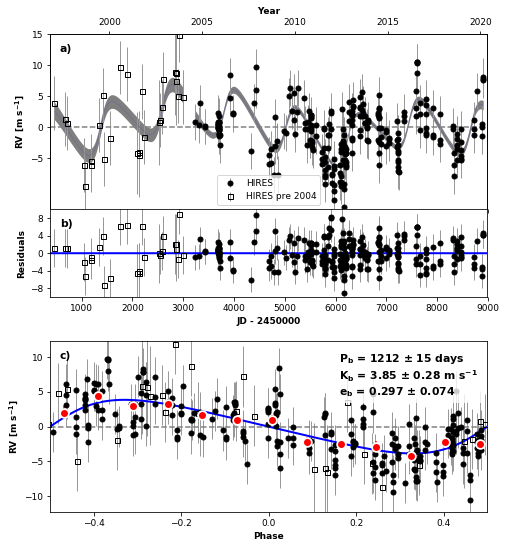

In [90]:
GPPlot = orbit_plots.GPMultipanelPlot(
         gppost, uparams=gppost.uparams,
         saveplot='3765_gp.pdf',
         subtract_gp_mean_model=False,
         plot_likelihoods_separately=False,
         subtract_orbit_model=False
         )
GPPlot.plot_multipanel()

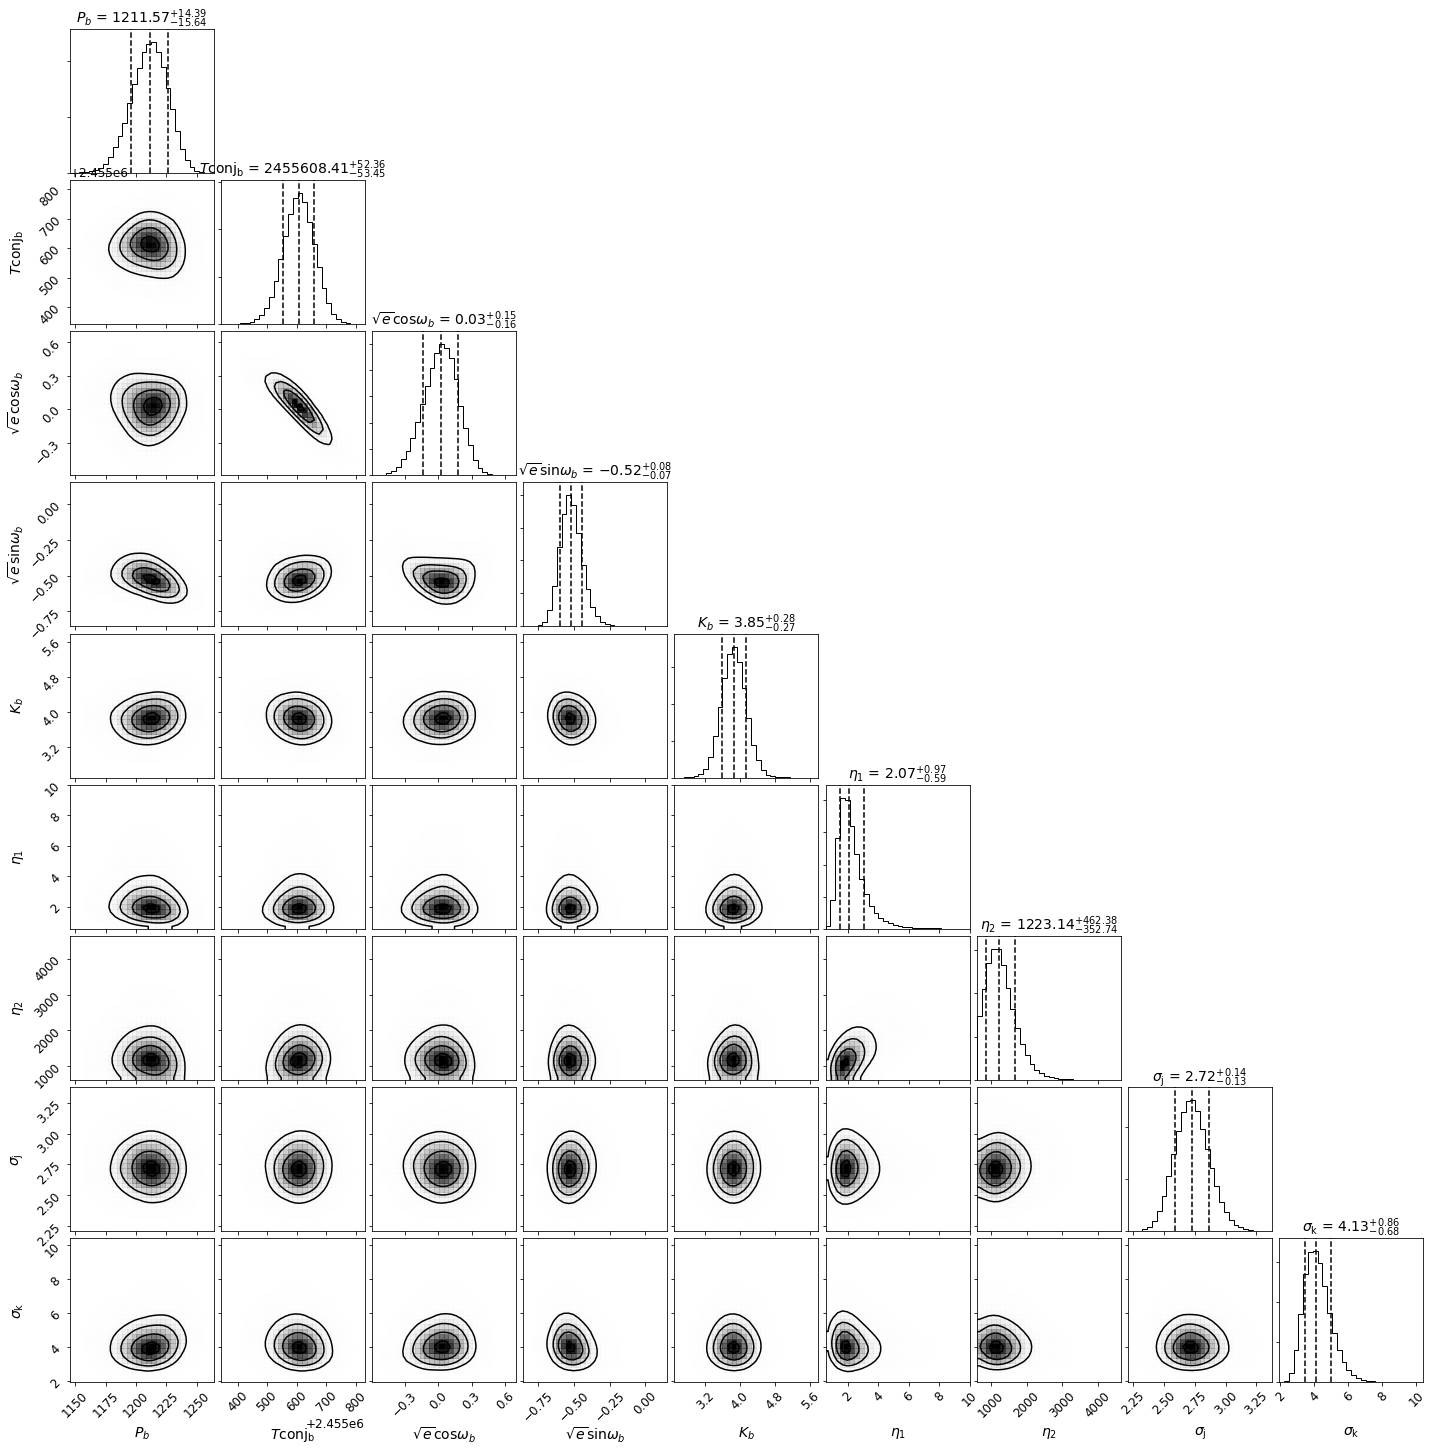

In [87]:
Corner = mcmc_plots.CornerPlot(gppost, cadence_chains)
Corner.plot()

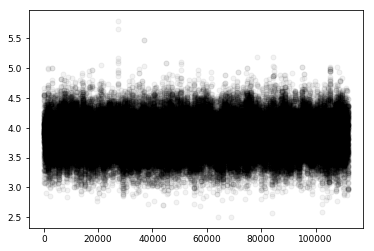

In [88]:
k = cadence_chains['k1'] #.query('k1 < 7.5 and gp_amp < 8')

fig, ax = plt.subplots()
ax.scatter(np.arange(len(k)), k, alpha=0.05, color='black')

In [65]:
cadence_chains.columns

Index(['Unnamed: 0', 'per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'gp_amp',
       'gp_length', 'jit_j', 'jit_k', 'lnprobability'],
      dtype='object')